<a href="https://colab.research.google.com/github/Mahdi-Golizadeh/VISION-TRANSFORMERS/blob/main/segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from transformers.utils import logging
logging.set_verbosity_error()

In [2]:
import transformers
sam_pipe = transformers.pipeline("mask-generation",
                                 "Zigeng/SlimSAM-uniform-77",)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/364 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/38.9M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

In [4]:
!wget http://www.llamalove.com/images/llamalineup2a.jpg

--2024-06-22 22:03:39--  http://www.llamalove.com/images/llamalineup2a.jpg
Resolving www.llamalove.com (www.llamalove.com)... 216.110.146.38
Connecting to www.llamalove.com (www.llamalove.com)|216.110.146.38|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 144763 (141K) [image/jpeg]
Saving to: ‘llamalineup2a.jpg’

llamalineup2a.jpg   100%[===================>] 141.37K   197KB/s    in 0.7s    

2024-06-22 22:03:40 (197 KB/s) - ‘llamalineup2a.jpg’ saved [144763/144763]



In [5]:
output = sam_pipe("llamalineup2a.jpg", points_per_batch= 32)

In [6]:
import numpy as np
import torch
import matplotlib.pyplot as plt

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3),
                                np.array([0.6])],
                               axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0),
                               w,
                               h, edgecolor='green',
                               facecolor=(0,0,0,0),
                               lw=2))

def show_boxes_on_image(raw_image, boxes):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    for box in boxes:
      show_box(box, plt.gca())
    plt.axis('on')
    plt.show()

def show_points_on_image(raw_image, input_points, input_labels=None):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
      labels = np.ones_like(input_points[:, 0])
    else:
      labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    plt.axis('on')
    plt.show()

def show_points_and_boxes_on_image(raw_image,
                                   boxes,
                                   input_points,
                                   input_labels=None):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
      labels = np.ones_like(input_points[:, 0])
    else:
      labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    for box in boxes:
      show_box(box, plt.gca())
    plt.axis('on')
    plt.show()


def show_points_and_boxes_on_image(raw_image,
                                   boxes,
                                   input_points,
                                   input_labels=None):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
      labels = np.ones_like(input_points[:, 0])
    else:
      labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    for box in boxes:
      show_box(box, plt.gca())
    plt.axis('on')
    plt.show()


def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0],
               pos_points[:, 1],
               color='green',
               marker='*',
               s=marker_size,
               edgecolor='white',
               linewidth=1.25)
    ax.scatter(neg_points[:, 0],
               neg_points[:, 1],
               color='red',
               marker='*',
               s=marker_size,
               edgecolor='white',
               linewidth=1.25)


def fig2img(fig):
    """Convert a Matplotlib figure to a PIL Image and return it"""
    import io
    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    img = Image.open(buf)
    return img


def show_mask_on_image(raw_image, mask, return_image=False):
    if not isinstance(mask, torch.Tensor):
      mask = torch.Tensor(mask)

    if len(mask.shape) == 4:
      mask = mask.squeeze()

    fig, axes = plt.subplots(1, 1, figsize=(15, 15))

    mask = mask.cpu().detach()
    axes.imshow(np.array(raw_image))
    show_mask(mask, axes)
    axes.axis("off")
    plt.show()

    if return_image:
      fig = plt.gcf()
      return fig2img(fig)




def show_pipe_masks_on_image(raw_image, outputs):
  plt.imshow(np.array(raw_image))
  ax = plt.gca()
  for mask in outputs["masks"]:
      show_mask(mask, ax=ax, random_color=True)
  plt.axis("off")
  plt.show()

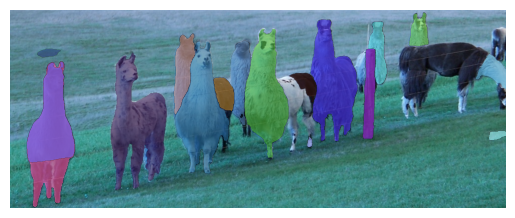

In [8]:
import cv2
img = cv2.imread("llamalineup2a.jpg")
show_pipe_masks_on_image(img, output)

In [9]:
model = transformers.SamModel.from_pretrained(
    "Zigeng/SlimSAM-uniform-77"
)

processor = transformers.SamProcessor.from_pretrained(
    "Zigeng/SlimSAM-uniform-77"
)

In [10]:
model

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 168, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((168,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=168, out_features=504, bias=True)
          (proj): Linear(in_features=168, out_features=168, bias=True)
        )
        (layer_norm2): LayerNorm((168,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=168, out_features=696, bias=True)
          (lin2): Linear(in_features=696, out_features=168, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(168, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
      (c

In [11]:
img.shape

(400, 1000, 3)

In [32]:
input_points = [[[220, 220]]]

In [33]:
inputs = processor(
    img,
    input_points= input_points,
    return_tensors= "pt"
)

In [34]:
import torch
with torch.no_grad():
  outputs = model(**inputs)

In [35]:
predicted_masks = processor.image_processor.post_process_masks(
    outputs.pred_masks,
    inputs["original_sizes"],
    inputs["reshaped_input_sizes"]
)

In [36]:
len(predicted_masks)

1

In [37]:
predicted_mask = predicted_masks[0]
predicted_mask.shape

torch.Size([1, 3, 400, 1000])

In [38]:
outputs.iou_scores

tensor([[[0.9239, 0.8288, 0.7665]]])

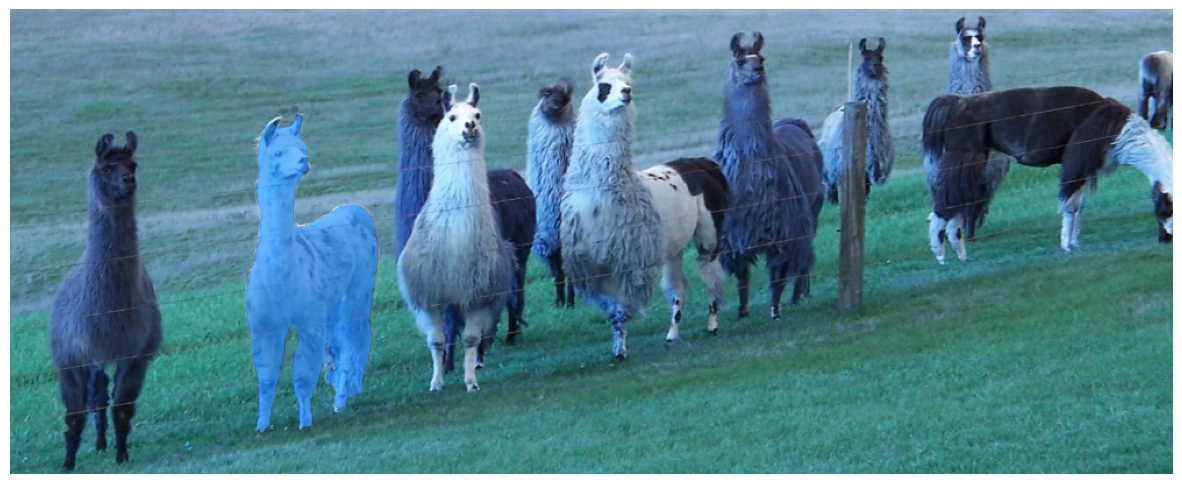

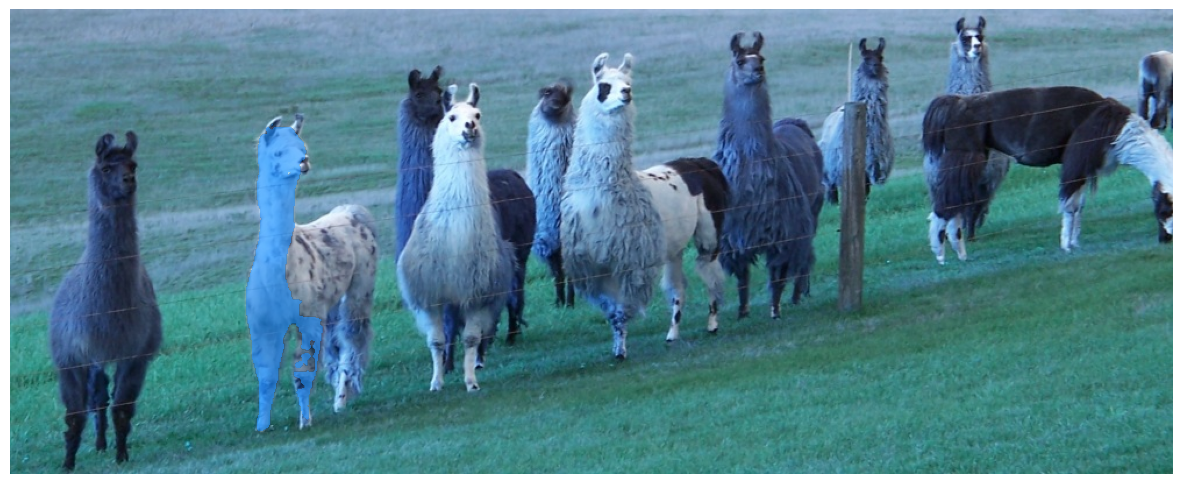

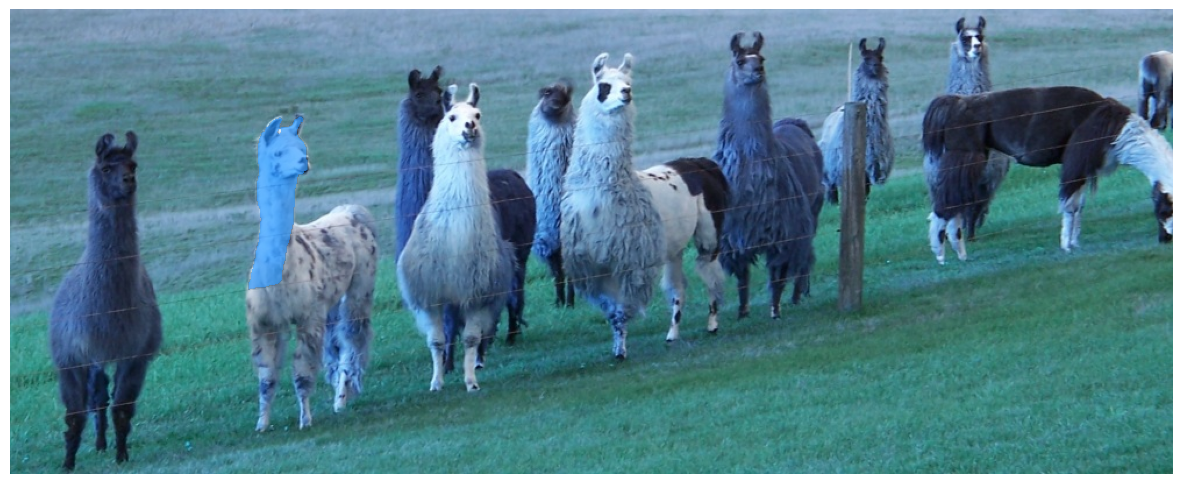

In [39]:
for i in range(3):
  show_mask_on_image(img, predicted_mask[:, i])